## Outline

#### Data set versions:
- Original dataset
- Synthesized dataset using SMOTE

#### Approaches:
- SVM + Grid Search
- SVM + Grid Search + Feature selection with F-score
- Anomaly detection SVM
- Ensemble SVM
  - Og data
  - Synthesized data
  - F-score filtered data

#### Evaluation Metrics:
- ROC
- F-score (Precision Recall)
- Confusion matrix
- Accuracy

In [251]:
import numpy as np
import pandas as pd

from collections import defaultdict

from imblearn.over_sampling import SMOTE

from sklearn.svm import SVC
from sklearn.svm import OneClassSVM

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
# from sklearn.metrics import precision_score
# from sklearn.metrics import recall_score

from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

# DATA = 'dataset/loan_one_hot_encoded.csv'
DATA = 'dataset/data.csv'
SYN_DATA = 'dataset/syn_data.csv'

In [17]:
original_df = pd.read_csv(DATA)
synthesized_df = pd.read_csv(SYN_DATA)

OG_TARGET = original_df['loan_created']
OG_FEATURES = original_df.drop(['loan_created', 'application_id'], axis=1)

SYN_TARGET = synthesized_df['loan_approved']
SYN_FEATURES = synthesized_df.drop(['loan_approved'], axis=1)

# scale features to 0 mean & unit var
X = StandardScaler().fit_transform(OG_FEATURES)
Y = OG_TARGET

X_os = StandardScaler().fit_transform(SYN_FEATURES)
Y_os = SYN_TARGET

print(' OG dataset: ', X.shape, Y.shape, np.unique(Y, return_counts=True))
print('SYN dataset: ', X_os.shape, Y_os.shape, np.unique(Y_os, return_counts=True))

 OG dataset:  (219, 242) (219,) (array([0, 1]), array([210,   9]))
SYN dataset:  (234, 242) (234,) (array([0, 1]), array([210,  24]))


In [18]:
# drop_cols = ['loan_created', 'application_id',
# #              'firm_type_Proprietorship',
#              'average_business_inflow'
#             ]
# df = pd.read_csv(DATA)
# Y = df['loan_created']
# og_X = df.drop(drop_cols, axis=1)

# imp = Imputer()
# imputed_X = imp.fit_transform(og_X)

# # X = imputed_X
# scl = StandardScaler()
# X = scl.fit_transform(imputed_X)

# X.shape, Y.shape, np.unique(Y, return_counts=True)

In [19]:
# sm = SMOTE(random_state = 44, ratio = {0:221, 1:24})
# X_os, Y_os = sm.fit_sample(X, Y)

# X_os.shape, Y_os.shape, np.unique(Y_os, return_counts=True)

In [206]:
class GridSearchCV:
    def __init__(self, param_grid, clf, pos_label, cv=5):
        self.param_list_ = list(ParameterGrid(param_grid))
        self.cv = cv
        self.pos_label = pos_label
        self.clf = clf
        
        self.overfit_ = [[] for _ in range(len(self.param_list_))]
        
        # evaluation scores
        self.accuracy_scores_ = ([[] for _ in range(len(self.param_list_))])
        self.precision_ = [[] for _ in range(len(self.param_list_))]
        self.recall_ = [[] for _ in range(len(self.param_list_))]
        self.f1_scores_ = [[] for _ in range(len(self.param_list_))]
        self.fpr_ = [[] for _ in range(len(self.param_list_))]
        self.tpr_ = [[] for _ in range(len(self.param_list_))]
        self.auc_scores_ = [[] for _ in range(len(self.param_list_))]        
        
    def fit(self, X, y):
        skf = StratifiedKFold(n_splits=self.cv)
        for train_index, test_index in skf.split(X, y):
            for idx, params in enumerate(self.param_list_):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                self.clf.set_params(**params)
                self.clf.fit(X_train, y_train) # probability=True, class_weight='balanced', 
                y_pred = self.clf.predict(X_test)
                if getattr(self.clf, "predict_proba", None):
                    y_probab = self.clf.predict_proba(X_test)
                else:
                    y_pred[y_pred == -1] = 0

                if np.all(y_pred[0] == y_pred):
                    # all values predicted are same;
                    self.overfit_[idx].append(True)

                    self.precision_[idx].append([])
                    self.recall_[idx].append([])
                    self.f1_scores_[idx].append(np.nan)

                    if getattr(self.clf, "predict_proba", None):
                        self.fpr_[idx].append([])
                        self.tpr_[idx].append([])
                        self.auc_scores_[idx].append(np.nan)
                else:
                    self.overfit_[idx].append(False)
                    precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred, pos_label=self.pos_label)
                    self.precision_[idx].append(precision)
                    self.recall_[idx].append(recall)
                    self.f1_scores_[idx].append(f1_score(y_test, y_pred))
                    if getattr(self.clf, "predict_proba", None):
                        fpr, tpr, roc_thresholds = roc_curve(y_test, y_probab[:,1], pos_label=self.pos_label)
                        self.fpr_[idx].append(fpr)
                        self.tpr_[idx].append(tpr)
                        self.auc_scores_[idx].append(auc(fpr, tpr))


                self.accuracy_scores_[idx].append(accuracy_score(y_test, y_pred))
        
        self.average_accuracy_param_ = np.array([np.average(_) for _ in self.accuracy_scores_])
    
        self.accuracy_scores_ = np.array(self.accuracy_scores_)
        self.precision_ = np.array(self.precision_)
        self.recall_ = np.array(self.recall_)
        self.f1_scores_ = np.array(self.f1_scores_)
        self.fpr_ = np.array(self.fpr_)
        self.tpr_ = np.array(self.tpr_)
        self.auc_scores_ = np.array(self.auc_scores_)
            
    def print_results(self, show_overfit=False):
        for _idx in range(len(self.average_accuracy_param_)):
            if not show_overfit and np.any(self.overfit_[_idx]):
                continue
            print('-'*40)
            print('overfit: ', np.any(self.overfit_[_idx]), np.unique(self.overfit_[_idx], return_counts=True))
            print('params:', self.param_list_[_idx])
            print('avg acc: ', self.average_accuracy_param_[_idx])
            print('f1 score:', np.average(gscv.f1_scores_[_idx]))
            print('auc: ', np.average(self.auc_scores_[_idx]))

In [244]:
class FScoreFeatureSelection:
    ''' Feature Selection based on F-Score of features '''
    
    def __init__(self, clf, param_grid, pos_label):
        self.clf = clf
        self.param_grid = param_grid
        self.pos_label = pos_label
        
    def _split_per_class(self, X, Y):
        return (np.array([_.ravel() for _ in X[np.argwhere(Y == self.pos_label)]]), 
                np.array([_.ravel() for _ in X[np.argwhere(Y != self.pos_label)]]))
    
    def _new_x(self, low_th, high_th):
        chosen_feature_indices = []
        for idx, fc in enumerate(self.f_scores):
            if fc >= low_th and fc <= high_th:
                chosen_feature_indices.append(idx)
        return self._X[:, chosen_feature_indices]
#         tmp = self.f_scores[self.f_scores >= low_th]
#         tmp = tmp[tmp <= high_th]
#         chosen_feature_indices = np.searchsorted(self.f_scores, tmp)
#         print(self.f_scores)
#         print(tmp)
#         print(chosen_feature_indices)
#         return self._X[:, chosen_feature_indices]
        
    def fit(self, X, Y, thresholds):
        self._thresholds = thresholds
        self._pos_x, self._neg_x = self._split_per_class(X, Y)
        self._X, self._Y = X, Y
        self.f_scores = np.array([self._f(i) for i in range(X.shape[1])]) # f-scores per feature
        gscv_objs = []
        
        for low_th, high_th in thresholds:
            new_X = self._new_x(low_th, high_th) # generate the new feature matrix based on chosen features
            
            # do 5-fold cross-validation on new_x using self.clf
            gscv = GridSearchCV(self.param_grid, self.clf, self.pos_label)
            gscv.fit(new_X, self._Y)
            gscv_objs.append(gscv)
        self.gscv_objs = np.array(gscv_objs)
    
    def _f(self, i):
        ''' Calculate F-score of the ith feature '''
        X, Y = self._X, self._Y
        x_ip_avg = np.average(self._pos_x[:, i]) # Average of the ith feature of positive dataset
        x_in_avg = np.average(self._neg_x[:, i]) # Average of the ith feature of negative dataset
        x_i_avg = np.average(X[:, i]) # Average of the ith feature of whole dataset
        
        _num = ((x_ip_avg - x_i_avg)**2 + (x_in_avg - x_i_avg)**2)
        
        _den = (((1/(self._pos_x.shape[0]-1)) * np.sum([(self._pos_x[k][i] - x_ip_avg)**2 for k in range(self._pos_x.shape[0])])) +
                ((1/(self._neg_x.shape[0]-1)) * np.sum([(self._neg_x[k][i] - x_in_avg)**2 for k in range(self._neg_x.shape[0])])))
        
        return _num/_den
    
    def new_X(low_th, high_th):
        return self._new_x(low_th, high_th)
        

In [294]:
param_grid = [
  {'C': [.1, .5, 1, 5, 10], 
   'gamma': ['auto'], 'kernel': ['rbf', 'sigmoid'], 
   'probability': [True], 'class_weight': ['balanced']},
 ]
thresholds = [(.004, .02)]#, (.2, .8), (.2, .9), (.2, .7), (.2, .6)]
# gscv = GridSearchCV(param_grid, clf, pos_label=1, cv=5)
fs = FScoreFeatureSelection(SVC(), param_grid, pos_label=1)
fs.fit(X_os, Y_os, thresholds)

/Users/sahil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in double_scalars


239
223
127 96


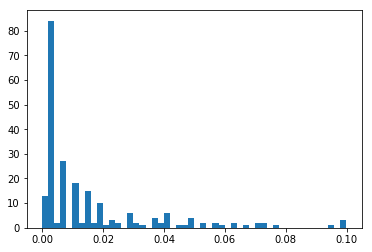

In [295]:
xs = fs.f_scores[~np.isnan(fs.f_scores)]
print(len(xs))
xs = xs[xs <= .1]
print(len(xs))
print(len(xs[xs >= .004]), len(xs[xs < .004]))
plt.hist(xs, bins=50)
plt.show()
# fs.f_scores[~np.isnan(fs.f_scores)].shape, fs.f_scores.shape

In [296]:
for i, _g in enumerate(fs.gscv_objs):
    print('**'*20)
    print(fs._thresholds[i])
    _g.print_results()

****************************************
(0.004, 0.02)
----------------------------------------
overfit:  False (array([False]), array([5]))
params: {'C': 0.1, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'rbf', 'probability': True}
avg acc:  0.6069380203515264
f1 score: 0.7166666666666666
auc:  0.8514285714285714
----------------------------------------
overfit:  False (array([False]), array([5]))
params: {'C': 0.5, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'rbf', 'probability': True}
avg acc:  0.6111933395004626
f1 score: 0.8899999999999999
auc:  0.8676190476190477
----------------------------------------
overfit:  False (array([False]), array([5]))
params: {'C': 0.5, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'sigmoid', 'probability': True}
avg acc:  0.39814986123959295
f1 score: 0.7238095238095238
auc:  0.2928571428571428
----------------------------------------
overfit:  False (array([False]), array([5]))
params: {'C': 1, 'class_weight': 'balance

## grid search on synthesized data

In [65]:
param_grid = [
  {'C': [.1, .5, 1, 5, 10], 
   'gamma': ['auto'], 'kernel': ['rbf', 'sigmoid'], 
   'probability': [True], 'class_weight': ['balanced']},
 ]
clf = SVC()
gscv = GridSearchCV(param_grid, clf, pos_label=1, cv=10)
gscv.fit(X_os, Y_os)
# vars(gscv)
gscv.print_results()

----------------------------------------
overfit:  False (array([False]), array([10]))
params: {'C': 0.1, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'rbf', 'probability': True}
avg acc:  0.9489130434782609
f1 score: 0.7166666666666666
auc:  0.95
----------------------------------------
overfit:  False (array([False]), array([10]))
params: {'C': 0.1, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'sigmoid', 'probability': True}
avg acc:  0.9356884057971016
f1 score: 0.7166666666666667
auc:  0.942063492063492
----------------------------------------
overfit:  False (array([False]), array([10]))
params: {'C': 0.5, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'rbf', 'probability': True}
avg acc:  0.9789855072463769
f1 score: 0.8899999999999999
auc:  0.9841269841269842
----------------------------------------
overfit:  False (array([False]), array([10]))
params: {'C': 0.5, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'sigmoid', 'probability': True}
av

## grid search on og data

In [22]:
param_grid = [
  {'C': [5, 10, 20, 40, 80], # .1, .5, 1, 
   'gamma': ['auto'], 'kernel': ['poly', 'sigmoid'], 
   'degree': [2, 3, 4, 5],
   'probability': [True], 'class_weight': ['balanced']},
 ]
clf = SVC()
gscv = GridSearchCV(param_grid, clf, pos_label=1, cv=9)
gscv.fit(X, Y)
# vars(gscv)
gscv.print_results()

----------------------------------------
overfit:  False (array([False]), array([9]))
params: {'C': 5, 'class_weight': 'balanced', 'degree': 2, 'gamma': 'auto', 'kernel': 'sigmoid', 'probability': True}
avg acc:  0.8272222222222222
f1 score: 0.024691358024691357
auc:  0.4840982286634461
----------------------------------------
overfit:  False (array([False]), array([9]))
params: {'C': 5, 'class_weight': 'balanced', 'degree': 3, 'gamma': 'auto', 'kernel': 'sigmoid', 'probability': True}
avg acc:  0.8272222222222222
f1 score: 0.024691358024691357
auc:  0.40881642512077293
----------------------------------------
overfit:  False (array([False]), array([9]))
params: {'C': 5, 'class_weight': 'balanced', 'degree': 4, 'gamma': 'auto', 'kernel': 'sigmoid', 'probability': True}
avg acc:  0.8272222222222222
f1 score: 0.024691358024691357
auc:  0.4655797101449275
----------------------------------------
overfit:  False (array([False]), array([9]))
params: {'C': 5, 'class_weight': 'balanced', 'deg

## anomaly detection grid search on og data

In [23]:
param_grid = [
  {'nu': np.arange(.1, 1.0, 0.1), 
   'gamma': ['auto'], 'kernel': ['poly'],
   'degree': [2, 3, 4, 5, 6, 7]},
 ]
clf = OneClassSVM()
gscv = GridSearchCV(param_grid, clf, pos_label=1, cv=5)
gscv.fit(X, Y)
# vars(gscv)
gscv.print_results()

----------------------------------------
overfit:  False (array([False]), array([5]))
params: {'degree': 2, 'gamma': 'auto', 'kernel': 'poly', 'nu': 0.1}
avg acc:  0.8219873150105709
f1 score: 0.07636363636363637
auc:  nan
----------------------------------------
overfit:  False (array([False]), array([5]))
params: {'degree': 2, 'gamma': 'auto', 'kernel': 'poly', 'nu': 0.2}
avg acc:  0.8587737843551798
f1 score: 0.08444444444444446
auc:  nan
----------------------------------------
overfit:  False (array([False]), array([5]))
params: {'degree': 2, 'gamma': 'auto', 'kernel': 'poly', 'nu': 0.30000000000000004}
avg acc:  0.8770613107822411
f1 score: 0.09444444444444444
auc:  nan
----------------------------------------
overfit:  False (array([False]), array([5]))
params: {'degree': 2, 'gamma': 'auto', 'kernel': 'poly', 'nu': 0.4}
avg acc:  0.8861522198731502
f1 score: 0.10714285714285716
auc:  nan


/Users/sahil/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:1128: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/sahil/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## anomaly detection grid search synthesized og data

In [24]:
param_grid = [
  {'nu': np.arange(.1, 1.0, 0.1), 
   'gamma': ['auto'], 'kernel': ['poly'],
   'degree': [2, 3, 4, 5, 6, 7]},
 ]
clf = OneClassSVM()
gscv = GridSearchCV(param_grid, clf, pos_label=1, cv=5)
gscv.fit(X_os, Y_os)
# vars(gscv)
gscv.print_results()

----------------------------------------
overfit:  False (array([False]), array([5]))
params: {'degree': 2, 'gamma': 'auto', 'kernel': 'poly', 'nu': 0.1}
avg acc:  0.8078630897317298
f1 score: 0.36898944193061844
auc:  nan
----------------------------------------
overfit:  False (array([False]), array([5]))
params: {'degree': 2, 'gamma': 'auto', 'kernel': 'poly', 'nu': 0.2}
avg acc:  0.850786308973173
f1 score: 0.4324675324675325
auc:  nan
----------------------------------------
overfit:  False (array([False]), array([5]))
params: {'degree': 2, 'gamma': 'auto', 'kernel': 'poly', 'nu': 0.30000000000000004}
avg acc:  0.8506012950971321
f1 score: 0.3024708624708624
auc:  nan
----------------------------------------
overfit:  False (array([False]), array([5]))
params: {'degree': 2, 'gamma': 'auto', 'kernel': 'poly', 'nu': 0.4}
avg acc:  0.8506012950971323
f1 score: 0.2630769230769231
auc:  nan
----------------------------------------
overfit:  False (array([False]), array([5]))
params: {'

/Users/sahil/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:1128: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/sahil/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## ensemble grid search on og data

In [62]:
params = {'C': 10, 'class_weight': 'balanced', 'degree': 3, 'gamma': 'auto', 'kernel': 'sigmoid', 'probability': True}
clf = BaggingClassifier(SVC(**params))
clf.fit(X, Y)
# clf.predict(X)
# cross_val_score(clf, X, Y, cv=5)
param_grid = [{'n_estimators': [50], 'max_samples': [1.0]}]
gscv = GridSearchCV(param_grid, clf, pos_label=1, cv=5)
gscv.fit(X, Y)
gscv.print_results(show_overfit=True)
print('-'*40)
vars(gscv)

----------------------------------------
overfit:  True (array([ True]), array([5]))
params: {'max_samples': 1.0, 'n_estimators': 50}
avg acc:  0.958985200845666
f1 score: nan
auc:  nan
----------------------------------------


{'param_list_': [{'max_samples': 1.0, 'n_estimators': 50}],
 'cv': 5,
 'pos_label': 1,
 '_clf': BaggingClassifier(base_estimator=SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
   decision_function_shape='ovr', degree=3, gamma='auto', kernel='sigmoid',
   max_iter=-1, probability=True, random_state=None, shrinking=True,
   tol=0.001, verbose=False),
          bootstrap=True, bootstrap_features=False, max_features=1.0,
          max_samples=1.0, n_estimators=50, n_jobs=1, oob_score=False,
          random_state=None, verbose=0, warm_start=False),
 'overfit_': [[True, True, True, True, True]],
 'accuracy_scores_': array([[0.95454545, 0.95454545, 0.95454545, 0.95454545, 0.97674419]]),
 'precision_': array([], shape=(1, 5, 0), dtype=float64),
 'recall_': array([], shape=(1, 5, 0), dtype=float64),
 'f1_scores_': array([[nan, nan, nan, nan, nan]]),
 'fpr_': array([], shape=(1, 5, 0), dtype=float64),
 'tpr_': array([], shape=(1, 5, 0), dtype=float64),
 'auc_scores_': array([[nan

## ensemble grid search on synthesized data

In [52]:
params = {'C': 10, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'rbf', 'probability': True}
clf = BaggingClassifier(SVC(**params))
clf.fit(X, Y)
param_grid = [{'n_estimators': [10], 'n_jobs': [-1], 'max_samples': [0.5]}]
gscv = GridSearchCV(param_grid, clf, pos_label=1, cv=5)
gscv.fit(X_os, Y_os)
gscv.print_results(show_overfit=True)
print('-'*40)
vars(gscv)

----------------------------------------
overfit:  False (array([False]), array([5]))
params: {'max_samples': 0.5, 'n_estimators': 10, 'n_jobs': -1}
avg acc:  0.9617021276595745
f1 score: 0.7563492063492064
auc:  0.9828571428571429
----------------------------------------


{'param_list_': [{'max_samples': 0.5, 'n_estimators': 10, 'n_jobs': -1}],
 'cv': 5,
 'pos_label': 1,
 '_clf': BaggingClassifier(base_estimator=SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
   decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
   max_iter=-1, probability=True, random_state=None, shrinking=True,
   tol=0.001, verbose=False),
          bootstrap=True, bootstrap_features=False, max_features=1.0,
          max_samples=0.5, n_estimators=10, n_jobs=-1, oob_score=False,
          random_state=None, verbose=0, warm_start=False),
 'overfit_': [[False, False, False, False, False]],
 'accuracy_scores_': array([[0.93617021, 0.93617021, 0.9787234 , 0.95744681, 1.        ]]),
 'precision_': array([[array([0.10638298, 1.        , 1.        ]),
         array([0.10638298, 1.        , 1.        ]),
         array([0.10638298, 1.        , 1.        ]),
         array([0.10638298, 1.        , 1.        ]), array([1., 1.])]],
       dtype=object),
 'recall